# Unsupervised Classification of Multiband Imagery with K-Means  
**Lecturer:** Liliana Castillo Villamor  
**Course:** Geoprocesamiento, Universidad Nacional de Colombia  
**Reference:** *Data Science – Unsupervised Classification of Satellite Images with K-Means Algorithm*  


##  Overview  

This notebook demonstrates an unsupervised land-cover classification using the
K-Means algorithm. The workflow mirrors the on-line tutorial [Available here](https://ml-gis-service.com/index.php/2020/10/14/data-science-unsupervised-classification-of-satellite-images-with-k-means-algorithm/) while adapting it
to a single multiband GeoTIFF subset (700× 700 px).
files.

**Key stages**

1. Import required libraries and create a clipped subset.  
2. Display a natural-colour RGB preview.  
3. Reshape the subset into a two-dimensional feature matrix.  
4. Build and train `ClusteredStack`, a class encapsulating the K-Means
   pipeline.  
5. Inspect the classified maps, inertia (Elbow method) and silhouette scores.  
6. Save the optimal map as a new raster.  


## 1. Import Libraries

In [2]:
# Standard and scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.windows as rwin

# Machine-learning tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Image-enhancement for visual interpretation
from skimage.exposure import equalize_adapthist


## 2. Load Datasets and generate a working subset

The original scene is considerably larger than required for this tutorial.  
To accelerate processing we clip a **centred 700 × 470 px window** and save it
as a new GeoTIFF. The steps executed in the following code cell are:

1. **Open** the full raster and retrieve its overall width and height.  
2. **Define** a `Window` object whose origin (`col_off`, `row_off`) is chosen so
   that the window is centred on the scene.  
3. **Read** only the pixels inside that window, yielding a much smaller
   multiband array.  
4. **Clone** the original metadata and update the height, width and affine
   transform so that the subset remains correctly georeferenced.  
5. **Write** the subset to disk with LZW compression and tiling enabled,
   producing `mi_stack_subset_400.tif`.  

From this point onwards the notebook uses the lightweight subset, greatly
reducing memory consumption and execution time.


| Variable | Meaning | Why we need it |  
|----------|---------|----------------|  
| `H`, `W` | Total height and width (pixels) of the original scene. | Used to calculate the offsets that centre the subset window. |  
| `win` | A `rasterio.windows.Window` object. | Specifies the exact rows/columns (origin + size) to extract. |  
| `subset` | A NumPy array holding the pixel values of all bands inside the window. | Becomes the in-memory image that is later written to disk. |  
| `meta` | A dictionary copied from the source raster’s metadata, then amended for the smaller image (new height, width and affine transform). | Ensures the subset inherits correct CRS, datum and geotransform when saved. |  


In [ ]:
raster_path = r'./data/image_export3.tif'# Path to the original image

#Path to an image subset (as the original one is too large)
subset_path = r'./data/subset_400.tif'
rows, cols  = 700, 700                             # subset size

with rio.open(raster_path) as src:
    H, W = src.height, src.width
    win  = rwin.Window((W - cols)//2, (H - rows)//2, cols, rows)
    subset = src.read(window=win)
    meta   = src.meta.copy()
    meta.update({"height": rows,
                 "width":  cols,
                 "transform": src.window_transform(win),
                 "compress": "lzw",
                 "tiled": True})

with rio.open(subset_path, "w", **meta) as dst:
    dst.write(subset)

print("Subset written in →", subset_path)

# --- Print key metadata fields to understand what is stored ---
print("Subset metadata summary:")
print(f"  Dimensions    → {meta['width']} × {meta['height']} px")
print(f"  Band count    → {meta['count']} bands")
print(f"  CRS           → {meta['crs']}")
print(f"  Data type     → {meta['dtype']}")
print(f"  Transform     →\n    {meta['transform']}")


Subset written in → ./data/subset_400.tif
Subset metadata summary:
  Dimensions    → 700 × 700 px
  Band count    → 4 bands
  CRS           → EPSG:32717
  Data type     → uint16
  Transform     →
    | 3.00, 0.00, 746994.00|
| 0.00,-3.00, 9066339.00|
| 0.00, 0.00, 1.00|


## 3 · Preview the subset in natural colour  


Satellite imagery often contains extreme pixel values caused by clouds, shadows,
or bright surfaces. For that reason, we apply a gentle 1-99 % linear stretch per band plus a mild gamma correction
to obtain a visually balanced image. It means:

- The darkest 1 % of pixel values are mapped to 0 (black),
- The brightest 1 % are mapped to 1 (white),
- The remaining 98 % are stretched linearly across the full 0–1 display range.

This technique improves contrast while ignoring outliers, making features easier
to distinguish without distorting overall appearance.

Each band (Red, Green, Blue) is stretched **independently** using its own
1–99 % range, ensuring colour balance and contrast are preserved.

**Gamma correction** adjusts the brightness of mid-tones without altering the
darkest or brightest pixels too drastically. It’s applied *after* stretching and
helps fine-tune image appearance for visual interpretation.

The gamma correction formula is defined as:

$$
\text{output\_pixel} = (\text{input\_pixel})^\gamma
$$

Where:

- $\text{input\_pixel}$ is the normalised pixel value (between 0 and 1),  
- $\gamma$ is the gamma coefficient,  
- $\text{output\_pixel}$ is the adjusted brightness value.  



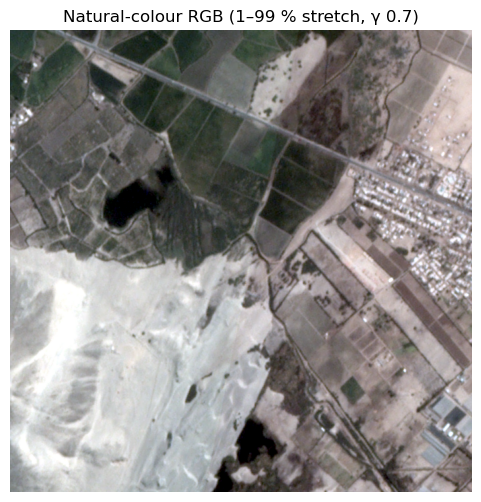

In [14]:
#· RGB preview (bands 4-3-2 )
with rio.open(subset_path) as src:
    img = src.read()

bands_rgb = (3,2,1)                            # R-G-B (1-based)
gamma     = 0.7                                 # contrast tweak

channels = []
for b in bands_rgb:
    band = img[b-1].astype(float)
    lo, hi = np.percentile(band, (1, 99))
    band = np.clip((band - lo) / (hi - lo), 0, 1)
    channels.append(band)

rgb = np.dstack(channels) ** gamma

plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title("Natural-colour RGB (1–99 % stretch, γ 0.7)")
plt.axis("off")
plt.show()


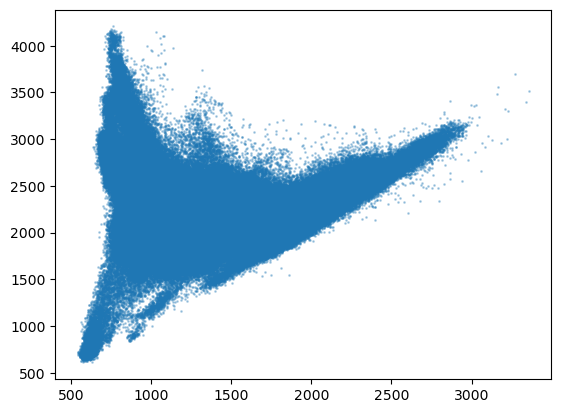

In [26]:
with rio.open(subset_path) as src:
    bands=src.read()

b2=bands[2].flatten()
b4=bands[3].flatten()

plt.scatter(b2,b4,s=1,alpha=0.3)
plt.show()


## 4 · The `ClusteredStack` class  

This class encapsulates the entire unsupervised classification pipeline.

#### `__init__(self, raster_path)`  Initialises the class instance.

#### `set_raster_stack(self)`  
Reads the raster and reshapes it into a format suitable for K-Means.

- Reads the entire stack: shape (bands, rows, cols).  
- Replaces `NaN` values with `0` to avoid issues during training.  
- Converts the 3D array to a 2D matrix of shape (n_pixels, n_bands)  
  — this is the input format required by scikit-learn.  
- Saves the image dimensions for future reshaping of the classification output.

---

#### `build_models(self, k_values)`  
Trains one K-Means model per value of *k* in the provided list.

- For each *k*:
  - Creates and fits a `KMeans` model using the reshaped image data.  
  - Stores the model object and the predicted labels.  
  - Computes the **inertia** (sum of squared distances within clusters).  
  - Computes the **silhouette score**, which measures cluster separation.  
- Reshapes the flat predicted labels back into image form (rows × cols).  
- Stores each classified raster in a list for later visualisation.

---

#### `show_clustered(self, cmap="Accent")`  
Displays all the classified maps corresponding to each *k*.

- Each image is shown in a separate plot with a categorical colourmap.  
- The colourbar helps interpret the numerical cluster labels.  
- This allows visual inspection of the spatial patterns produced by each *k*.

---

#### `show_inertia(self)`  
Plots the Elbow curve.

- The *inertia* score is plotted against *k*.  
- This helps identify the point where adding more clusters yields diminishing
  returns — the "elbow".  
- A lower inertia indicates more compact clusters.

---

#### `show_silhouette(self)`  
Plots the silhouette score for each *k*.

- The **silhouette score** ranges from –1 to 1:  
  - A high score (≈ 1) indicates well-separated, dense clusters.  
  - A low or negative score suggests overlapping or poorly defined clusters.  
- This metric complements the Elbow method by revealing the quality of
  separation between clusters.

---

Together, these methods allow the user to:  
1. Load a raster stack,  
2. Prepare it for unsupervised analysis,  
3. Explore different *k* values, and  
4. Select an appropriate number of clusters based on both visual and statistical cues.


In [9]:
# %% Listings 5-7 completos (adaptados)
class ClusteredStack:
    
    def __init__(self, raster_path): # Initialises the class instance.
        self.raster_path = raster_path # path to the multiband GeoTIFF (e.g., the 400×400 subset).  
        self.model_input = None #    the reshaped data matrix  
        self.height = self.width = self.depth = 0 # image dimensions
        self.k_range = [] # List of all k-values (number of clusters) to evaluate
        self.models = [] # Trained KMeans models for each k; stored for later inspection
        self.predicted_rasters = [] # Cluster label images (reshaped to raster size)
        self.inertia_scores = [] # Inertia values (sum of squared distances within clusters); used for Elbow method
        self.silhouette_scores = [] # Silhouette scores (measure of cluster separation); used for model selection

    
    def set_raster_stack(self):
        """Reads the raster and reshapes it into a format suitable for K-Means."""
        with rio.open(self.raster_path) as src:

            # Read all bands into a 3D NumPy array of shape (bands, rows, cols)
            stack = src.read()

             # Replace any NaN (Not-a-Number) values with zero. Avoids errors during clustering algorithms, which cannot handle NaNs
            stack = np.nan_to_num(stack)   
        # Extract the number of bands, rows, and columns from the raster's shape
        # These values are stored as object attributes for later use
        self.depth, self.height, self.width = stack.shape

        # Reshape the 3D array into a 2D matrix of shape (n_pixels, n_bands)
        # Each row now corresponds to one pixel, and each column to a spectral band
        # Transposition (.T) ensures the matrix has the correct shape for scikit-learn
        self.model_input = stack.reshape(self.depth, -1).T


    def build_models(self, k_values):
        """
            Trains one K-Means clustering model for each value of k provided in k_values.
         It stores the resulting models, cluster labels, and evaluation metrics.
        """

        # Convert the input iterable into a list and store it
        # This list defines the number of clusters to be tested (e.g. [3, 4, 5, ..., 10])
        self.k_range = list(k_values)

        # Initialise empty lists to store models, results, and metrics
        self.models, self.predicted_rasters = [], [] # Trained KMeans objects  - Cluster label images (reshaped to raster form)
        self.inertia_scores, self.silhouette_scores = [], [] # Inertia values for each k - # Silhouette scores for each k

        for k in self.k_range:

            # Create a KMeans model with k clusters
            # random_state ensures reproducibility; n_init specifies how many times the algorithm will run with different centroid seeds
            km = KMeans(n_clusters=k, random_state=42, n_init=10)

             # Fit the model to the reshaped raster and predict the cluster labels
             # This returns one label (cluster ID) per pixel
            labels = km.fit_predict(self.model_input)

            # Store the trained model
            self.models.append(km)

            # Record the inertia for this k (lower is better; used in Elbow method)
            self.inertia_scores.append(km.inertia_)

            # Calculate and store the silhouette score for this k
            # A higher silhouette score indicates better-defined clusters
            # Sampling is limited to 1000 points for performance reasons
            self.silhouette_scores.append(
                silhouette_score(self.model_input, labels, sample_size=1000)
            )

            # Reshape the flat list of labels back to image form (rows × cols)
            # This is required for visualising the classified image later
            self.predicted_rasters.append(labels.reshape(self.height, self.width))


    def show_clustered(self, cmap="Accent"):
        """
        Displays one classified raster image for each value of k.
        Each image uses a categorical colourmap for easy interpretation.
        """
        for k, img_cls in zip(self.k_range, self.predicted_rasters):
            plt.figure(figsize=(5, 5))
            plt.imshow(img_cls, cmap=cmap)
            plt.title(f"{k} clusters")
            plt.axis("off")
            plt.colorbar()
            plt.show()

    def show_inertia(self):
        """
        Plots the inertia values for each k to apply the Elbow method.
        Inertia measures how tightly the data points are clustered around their centroids.
        Lower values indicate more compact clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.inertia_scores, "o-")
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("Inertia")
        plt.title("Elbow method")
        plt.show()

    def show_silhouette(self):
        """
        Plots the silhouette scores for each k to assess clustering quality.
        Silhouette score ranges from -1 to 1, with higher values indicating
        better-defined, well-separated clusters.
        """
        plt.figure(figsize=(5, 4))
        plt.plot(self.k_range, self.silhouette_scores, "o-")
        plt.xlabel("Número de clusters (k)")
        plt.ylabel("Silhouette Coeff.s")
        plt.title("Silhouette scores")
        plt.show()


The following chunk reads a single multiband raster image, replace any `NoData` or `NaN` values with `0`, and restructure the array so that each row represents one pixel and each column represents one spectral band.
**

1. Opens the raster using `rasterio` within a `with` block to ensure the file is properly closed afterwards (safe resource handling).  
2. Reads all bands at once → resulting in a 3D array `stack` with shape `(bands, rows, cols)`.  
3. Replaces any missing or undefined values (`NaN`) with `0` using `np.nan_to_num()`.  
4. Stores the number of bands (`depth`), rows (`height`), and columns (`width`) as class attributes for use in later steps.  
5. Reshapes the 3D stack into a 2D matrix using `.reshape().T`, producing an array with shape `(n_pixels, n_bands)` — the required input format for scikit-learn algorithms like Kustering.


Este método reemplaza a *Listing 5: `ClusteredBands` – set bands stack method* del tutorialk K-Means.



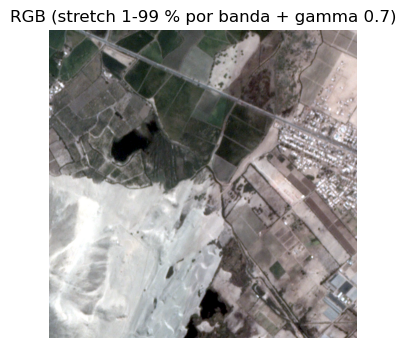

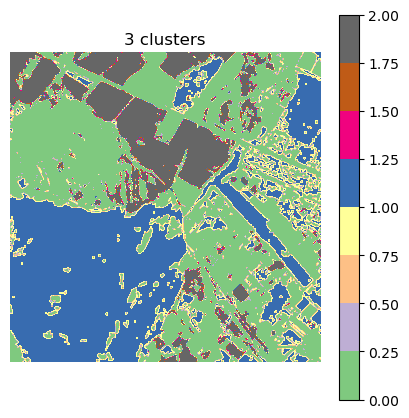

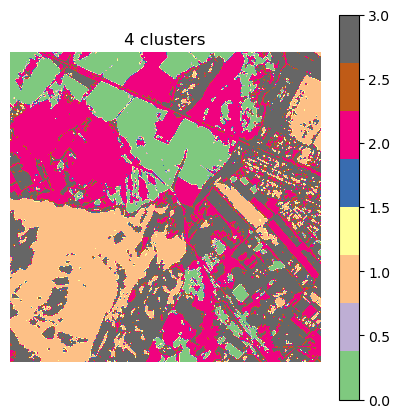

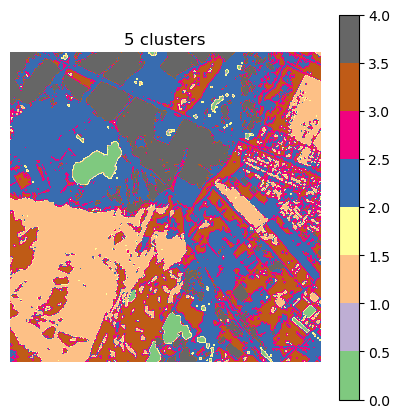

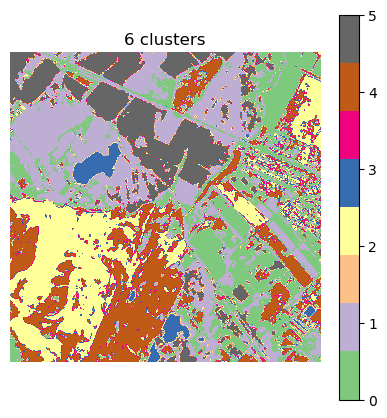

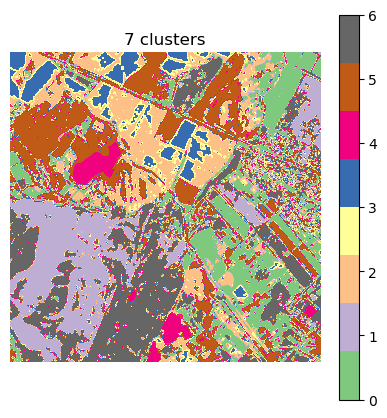

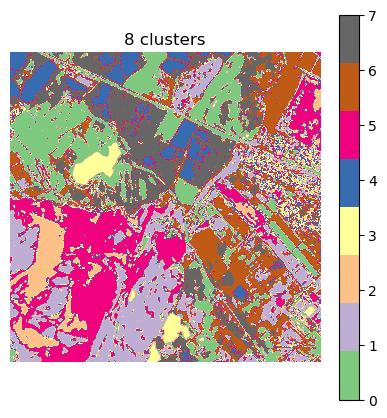

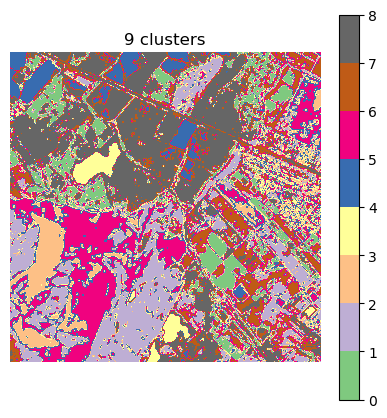

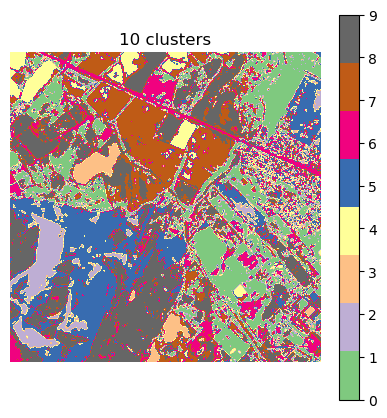

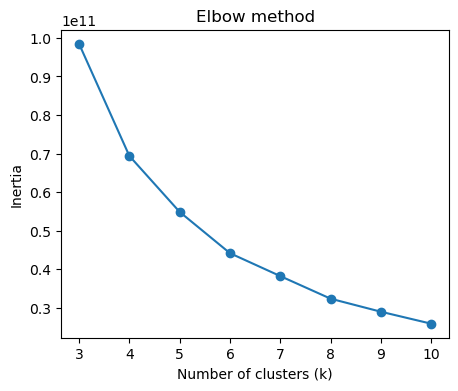

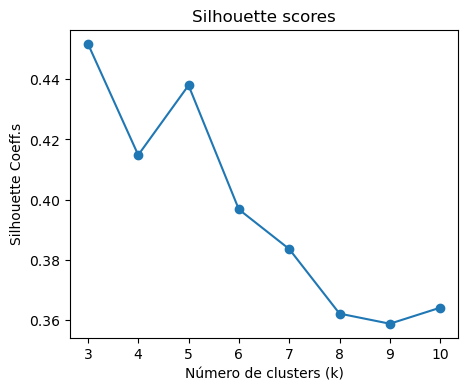

In [10]:
# ==== Model training and visualisation (tutorial-style layout) ====

# 1. Instantiate the object
# This creates an instance of the ClusteredStack class using the clipped raster
clustered_models = ClusteredStack(subset_path)

# Load the raster and reshape it into a 2D array of pixels × bands
clustered_models.set_raster_stack()

# 2. Define the range of k values (number of clusters to evaluate)
# Equivalent to testing k = 3, 4, ..., 10
ranges = np.arange(3, 11, 1)

# 3. Train the models
# For each k, this will:
# - Fit a KMeans model
# - Store the predicted labels
# - Compute inertia and silhouette scores
clustered_models.build_models(ranges)

# 4. Display the RGB preview again
# This step is optional but helps visually link the original image with the results
with rio.open(subset_path) as src:
    rgb_preview = src.read()                 # (bands, rows, cols)

plt.figure(figsize=(4,4))
plt.imshow(rgb)
plt.title("RGB (stretch 1-99 % por banda + gamma 0.7)")
plt.axis("off")
plt.show()

clustered_models.show_clustered()
clustered_models.show_inertia()

# --- Alias para mantener el nombre del tutorial ---
ClusteredStack.show_silhouette_scores = ClusteredStack.show_silhouette
clustered_models.show_silhouette_scores()


## 5. Workshop Submission Instructions  

For this workshop, each group must complete the following tasks and submit a report/notebook:

1. Select a study area of your choice.  
   You may use:
   - the Aberystwyth subset used in the supervised classification tutorial,  
   - the Amazon region or the  Andean region from the previous workshop.

2. Apply unsupervised segmentation using the K-Means algorithm.  
   - Choose an appropriate number of clusters (*k*) and justify your choice using inertia and silhouette scores.  
   - Display and interpret the spatial distribution of the resulting clusters.  

3. Incorporate the cluster labels as a categorical covariate into your classification model.

4. Evaluate classification performance using the same metrics as in the previous workshop.

5. Submit a link to the Jupyter notebook on GitHub

| **Criterion**                             | **Excellent (4)**                                                                                                                                                    | **Good (3)**                                                                                                        | **Satisfactory (2)**                                                                                                     | **Needs Improvement (1)**                                                               |
| ----------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------- |
| **Methodology and Execution**             | The workflow is implemented correctly and completely. All steps are clearly structured and well justified. Parameter choices (e.g., *k* range) are well explained.   | The main workflow is correct with only minor issues or missing justifications. Most steps are clearly implemented.  | The approach is partially implemented. Key components may be incomplete or lack explanation.                             | Methodology is incorrect or significantly incomplete. Workflow is difficult to follow.  |
| **Visualisation and Interpretation**     IB images and clustering outputs are clearly presented and properly interpreted. All figures are well labelled and aid understanding.                               | Visual outputs are provided and mostly clear. Some interpretation is present but may lack depth or clarity.         | Basic figures are included but poorly explained or not clearly linked to results.                                        | Visual outputs are missing, incorrect, or uninterpreted.                                |
| **Evaluation of Results**                 | All classification mettc.)  and thoroughly interpreted. The impact of clustering is clearly discussed.     | Most metrics are included and reasonably interpreted. Some discussion of cluster effects is present.                | Only basic metrics are evaluated. Interpretation is minimal or superficial.                                              | Metrics are missing or incorrect. No reflection on classification performance.          |
| **Documentation and Clarity of Notebook** | Notebook is exceptionally well documented. Markdown cells clearly explain the purpose of each step. Code is clean, readable, and accompanied by meaningful comments. | Good documentation. Markdown is present in most sections and explains the code clearly. Code is generally readable. | Limited documentation. Markdown cells are present but inconsistent or lack explanatory value. Code comments are minimal. | Notebook lacks Markdown explanations. Code is poorly organised and difficult to follow. |
